In [1]:
from active_learning.utils import dataset_to_tensors
import torch
import torch.distributions as dists
import hydra
from hydra import compose, initialize
from hydra.utils import call, instantiate
from omegaconf import OmegaConf
import yaml
import numpy as np
from active_learning.utils import TensorDataLoader, set_seed, CIFAR10_transform, dataset_to_tensors

import torch
import math
from torch import Tensor
from torchvision import transforms
from torchvision.datasets import MNIST
from sklearn.model_selection import train_test_split
from active_learning.active_dataset import *

In [2]:
import hydra
from hydra import compose, initialize
from hydra.utils import call, instantiate
from omegaconf import OmegaConf
import yaml

In [3]:
from src.utils import Dictionary

In [4]:
#!pip install laplace-torch
#!pip install torchvision
#!pip install batchbald_redux


In [5]:
with initialize(version_base=None, config_path="config"):
    cfg = compose(config_name="main", overrides=["data=mnist/unbalanced_pool", "experiment_name=mnist_unbalanced", "acquisition.objective=epig"])

#cfg.data['label_counts']['train']['10_classes_in_range(10)'] = 10

device = 'cpu'
#'cuda'
rng = call(cfg.rng)
data = instantiate(cfg.data, rng=rng)
data.torch()
data.to(device)

In [6]:
###EPIG Active data class

In [7]:
print(cfg.model)
cfg.trainer["n_optim_steps_max"] = 2
print(cfg.trainer["n_optim_steps_max"])

{'_target_': 'src.models.ConvolutionalNeuralNetwork', 'dropout_rate': 0.5}
2


In [8]:
print(cfg.trainer)

{'_target_': 'src.trainers.NeuralNetworkTrainer', 'early_stopping_metric': 'val_loss', 'early_stopping_patience': 5000, 'n_optim_steps_min': 0, 'n_optim_steps_max': 2, 'n_samples_test': 100, 'n_samples_train': 1, 'n_validations': 500, 'optimizer': {'_target_': 'torch.optim.SGD', '_partial_': True, 'lr': 0.01, 'weight_decay': 0.0001}, 'restore_best_model': True, 'verbose': False}


In [8]:
model = instantiate(cfg.model, input_shape=data.input_shape, output_size=data.n_classes)
model = model.to(device)
trainer = instantiate(cfg.trainer, model=model)

In [9]:
# val_loader=data.get_loader("val")
# #val_ds = val_loader.dataset
# #x_val, y_val = dataset_to_tensors(val_ds, device=device)
# for x_b, y_b in val_loader:
#     print(x_b.dtype)
#     print(y_b.dtype)
#     break

In [10]:
#len(val_loader.dataset)

In [11]:
train_log = trainer.train(
            train_loader=data.get_loader("train"),
            val_loader=data.get_loader("val"),
        )

No validation here
We are in restore_best_model if


In [12]:
cfg.acquisition.objective

'epig'

In [13]:
target_loader = data.get_loader("target")
target_inputs, _ = next(iter(target_loader))

scores = trainer.estimate_uncertainty(
    pool_loader=data.get_loader("val"),
    target_inputs=target_inputs,
    mode='bald',
    rng=rng,
    epig_probs_target=cfg.acquisition.epig_probs_target,
    epig_probs_adjustment=cfg.acquisition.epig_probs_adjustment,
    epig_using_matmul=cfg.acquisition.epig_using_matmul,
)

In [14]:
scores = scores.numpy()
scores = scores['bald']

acquired_pool_inds = np.argmax(scores)

In [15]:
acquired_pool_inds

43

In [ ]:
###Marglik

In [24]:
transform = transforms.ToTensor()
ds_cls = MNIST
device = 'cpu'

train_dataset = ds_cls(root='./data', train=True, download=True, transform=transform)
test_dataset = ds_cls(root='./data', train=True, download=True, transform=transform)

In [25]:
X, y = dataset_to_tensors(train_dataset, device=device)
x_test_full, y_test_full = dataset_to_tensors(test_dataset, device=device)
X = X[:2000]
y = y[:2000]
X.to(device)
y.to(device)

tensor([5, 0, 4,  ..., 5, 2, 0])

In [26]:
classes = torch.unique(y)
    
ixs_val = list()
for c in classes.cpu().numpy():
    ixs_val.append(np.random.choice(np.where(y.cpu() == c)[0], int(60/len(classes)), replace=False))
ixs_val_np = np.array(ixs_val).reshape(1,-1).squeeze()
X_val= X[ixs_val_np].detach().clone().to(device)
y_val = y[ixs_val_np].detach().clone().to(device)


In [27]:
import matplotlib.pyplot as plt
def plot_number_histogram(y_data_1, title):
 # Creating the histogram
    plt.hist(y_data_1, bins=np.arange(-0.5, 10.5, 1), align='mid', rwidth=0.8)

    plt.xlabel('Digits')
    plt.ylabel('Count')
    plt.title(title)

    plt.xticks(np.arange(0, 10))  # Display digits from 0 to 9 on the X-axis
    plt.grid(axis='y')  # Display gridlines on the Y-axis

    plt.show()

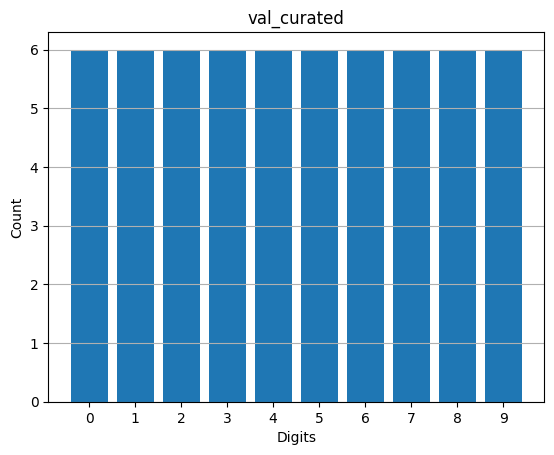

In [28]:
plot_number_histogram(y_val, "val_curated")

In [9]:
act_dataset = ActiveDataset(X, y, n_init=20, stratified=True)
tr_loader = act_dataset.get_train_loader(batch_size = 250)
#val_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
val_loader_marglik = TensorDataLoader(X[:50], y[:50], batch_size=250)

In [10]:
# val_loader_marglik=TensorDataLoader(X[:500], y[:500], batch_size=250)
# #val_ds_marglik = val_loader_marglik.dataset
# #x_val_marglik, y_val_marglik = dataset_to_tensors(val_ds_marglik, device=device)
# for x_b, y_b in val_loader_marglik:
#     print(x_b.dtype)
#     print(y_b.dtype)
#     break

In [11]:
model = instantiate(cfg.model, input_shape=data.input_shape, output_size=data.n_classes)
model = model.to(device)
trainer = instantiate(cfg.trainer, model=model)

In [12]:
train_log = trainer.train(
            train_loader=tr_loader,
            val_loader=val_loader_marglik,
        )

In [16]:
with torch.inference_mode():
    test_acc, test_loss = trainer.test(data.get_loader("test"))

In [13]:
target_loader = data.get_loader("target")
target_inputs, _ = next(iter(target_loader))

scores = trainer.estimate_uncertainty(
    pool_loader=val_loader_marglik,
    target_inputs=target_inputs,
    mode='bald',
    rng=rng,
    epig_probs_target=cfg.acquisition.epig_probs_target,
    epig_probs_adjustment=cfg.acquisition.epig_probs_adjustment,
    epig_using_matmul=cfg.acquisition.epig_using_matmul,
)

In [14]:
scores = scores.numpy()
scores = scores['bald']

acquired_pool_inds = np.argmax(scores)

In [15]:
acquired_pool_inds

34